C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training for 100 episodes...
Episode 1/100, Total Reward: 15
Episode 2/100, Total Reward: 5
Episode 3/100, Total Reward: 15
Episode 4/100, Total Reward: 33
Episode 5/100, Total Reward: 15
Episode 6/100, Total Reward: 1
Episode 7/100, Total Reward: 2
Episode 8/100, Total Reward: 37
Episode 9/100, Total Reward: 2
Episode 10/100, Total Reward: 5
Episode 11/100, Total Reward: 15
Episode 12/100, Total Reward: 2
Episode 13/100, Total Reward: 5
Episode 14/100, Total Reward: -2
Episode 15/100, Total Reward: -1
Episode 16/100, Total Reward: -1
Episode 17/100, Total Reward: -2
Episode 18/100, Total Reward: 20
Episode 19/100, Total Reward: 15
Episode 20/100, Total Reward: -1
Episode 21/100, Total Reward: 25
Episode 22/100, Total Reward: 15
Episode 23/100, Total Reward: 5
Episode 24/100, Total Reward: -1
Episode 25/100, Total Reward: 15
Episode 26/100, Total Reward: 5
Episode 27/100, Total Reward: 2
Episode 28/100, Total Reward: 5
Episode 29/100, Total Reward: 1
Episode 30/100, Total Reward: 9
Epi

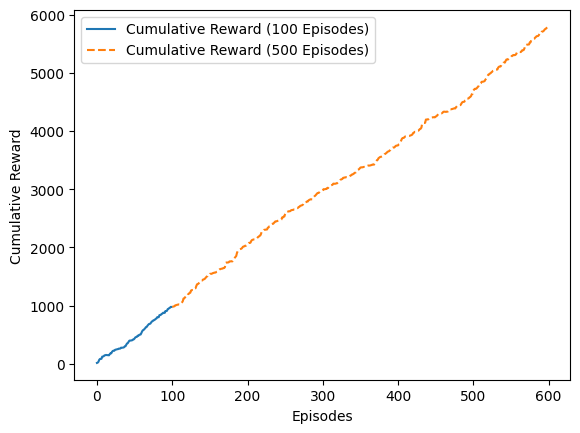

Average Reward (100 Episodes): 9.77
Average Reward (500 Episodes): 9.626


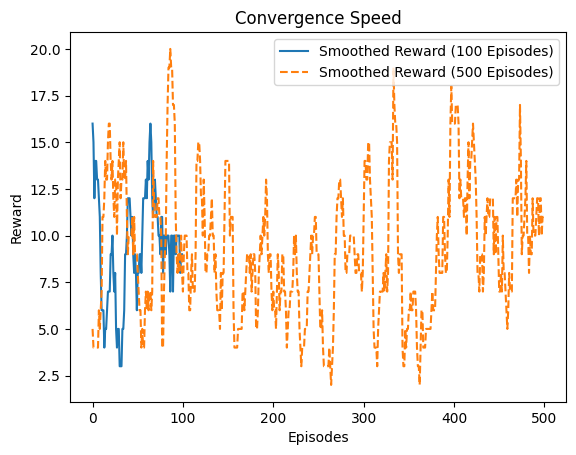

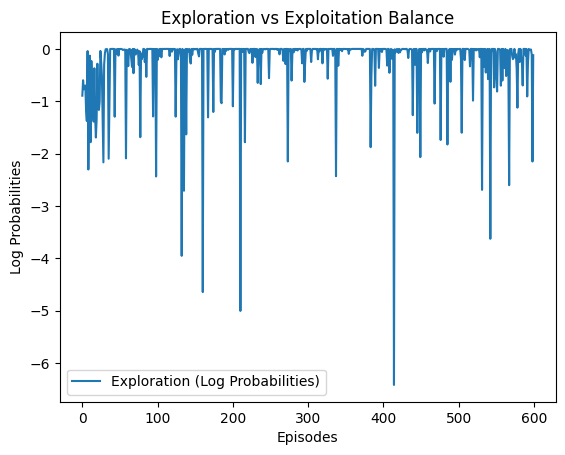

In [2]:
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
from scipy.ndimage import uniform_filter1d  # Import for smoothing

# Load and preprocess dataset
data = pd.read_csv("C:/Users/srini/DRL_Project/ecommerce_customer_data_large.csv")

# Preprocessing
relevant_columns = ['Customer Age', 'Product Category', 'Product Price', 'Gender']
data_subset = data[relevant_columns]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = encoder.fit_transform(data_subset[['Product Category', 'Gender']])
numerical_features = data_subset[['Customer Age', 'Product Price']].values

state_representation = np.hstack((numerical_features, encoded_columns))

# Normalize product price for better training
scaler = MinMaxScaler()
state_representation[:, 1:2] = scaler.fit_transform(state_representation[:, 1:2])

actions = encoder.categories_[0]
action_size = len(actions)
state_size = state_representation.shape[1]

# PPO Parameters
gamma = 0.99
epsilon_clip = 0.2
actor_lr = 0.0001
critic_lr = 0.0002
batch_size = 64
ppo_epochs = 10

# Reward function
def calculate_reward(action_type):
    rewards = {'click': 2, 'add_to_cart': 5, 'purchase': 15}
    penalties = {'no_action': -1}
    return rewards.get(action_type, penalties.get(action_type, 0))

# Build Actor Model
def build_actor(state_size, action_size):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(action_size, activation='softmax')  # Outputs probabilities
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=actor_lr))
    return model

# Build Critic Model
def build_critic(state_size):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='linear')  # Outputs state value
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=critic_lr), loss='mse')
    return model

# Initialize Actor and Critic
actor = build_actor(state_size, action_size)
critic = build_critic(state_size)

# Memory for PPO
class PPOBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

    def store(self, state, action, reward, value, log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

buffer = PPOBuffer()

# Choose an action using the Actor model
def choose_action(state):
    state = np.array([state])
    probs = actor.predict(state, verbose=0)[0]
    action = np.random.choice(len(probs), p=probs)
    log_prob = np.log(probs[action] + 1e-10)
    value = critic.predict(state, verbose=0)[0]
    return action, log_prob, value[0]

# Train PPO
def train_ppo(buffer):
    states = np.array(buffer.states, dtype=np.float32)
    actions = np.array(buffer.actions, dtype=np.int32)
    rewards = np.array(buffer.rewards, dtype=np.float32)
    values = np.array(buffer.values, dtype=np.float32)
    log_probs = np.array(buffer.log_probs, dtype=np.float32)
    dones = np.array(buffer.dones, dtype=np.float32)

    # Calculate advantages
    advantages = []
    discounted_reward = 0
    for reward, done in zip(rewards[::-1], dones[::-1]):
        if done:
            discounted_reward = 0
        discounted_reward = reward + gamma * discounted_reward
        advantages.append(discounted_reward)
    advantages = np.array(advantages[::-1], dtype=np.float32) - values

    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)

    # Update Actor and Critic
    for _ in range(ppo_epochs):
        with tf.GradientTape() as tape:
            action_probs = actor(states, training=True)
            selected_probs = tf.reduce_sum(action_probs * tf.one_hot(actions, action_size), axis=1)
            ratio = selected_probs / tf.exp(log_probs)
            clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon_clip, 1 + epsilon_clip)
            actor_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
        actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
        actor.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))

    critic_loss = critic.train_on_batch(states, advantages + values)
    return actor_loss, critic_loss

# Training Loop
def train_ppo_agent(episodes, max_steps, exploration_history, reward_history):
    for episode in range(episodes):
        state = random.choice(state_representation)
        total_reward = 0

        for step in range(max_steps):
            action, log_prob, value = choose_action(state)
            reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
            reward = calculate_reward(reward_type)
            next_state = random.choice(state_representation)
            done = random.choice([True, False])

            buffer.store(state, action, reward, value, log_prob, done)
            total_reward += reward
            state = next_state

            if done:
                break

        exploration_history.append(log_prob)
        reward_history.append(total_reward)
        train_ppo(buffer)
        buffer.clear()

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

# Training
reward_history_100 = []
reward_history_500 = []
exploration_history_100 = []
exploration_history_500 = []

print("Training for 100 episodes...")
train_ppo_agent(100, 200, exploration_history_100, reward_history_100)

print("Training for 500 episodes...")
train_ppo_agent(500, 200, exploration_history_500, reward_history_500)

# Combine histories for analysis
full_reward_history = reward_history_100 + reward_history_500
full_exploration_history = exploration_history_100 + exploration_history_500

# Plot cumulative reward
plt.plot(np.cumsum(reward_history_100), label="Cumulative Reward (100 Episodes)")
plt.plot(range(len(reward_history_100), len(full_reward_history)), 
         np.cumsum(reward_history_500) + np.cumsum(reward_history_100)[-1], 
         label="Cumulative Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()

# Average Reward
avg_reward_100 = np.mean(reward_history_100)
avg_reward_500 = np.mean(reward_history_500)
print(f"Average Reward (100 Episodes): {avg_reward_100}")
print(f"Average Reward (500 Episodes): {avg_reward_500}")

# Convergence Speed
plt.plot(uniform_filter1d(reward_history_100, size=10), label="Smoothed Reward (100 Episodes)")
plt.plot(uniform_filter1d(reward_history_500, size=10), label="Smoothed Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Convergence Speed")
plt.legend()
plt.show()

# Exploration vs Exploitation
plt.plot(range(len(full_exploration_history)), full_exploration_history, label="Exploration (Log Probabilities)")
plt.xlabel("Episodes")
plt.ylabel("Log Probabilities")
plt.title("Exploration vs Exploitation Balance")
plt.legend()
plt.show()


In [3]:
# Evaluation Function for PPO
def evaluate_ppo_model(actor, critic, state_representation, episodes=100, max_steps=200):
    total_rewards = []
    total_clicks = 0
    total_add_to_cart = 0
    total_purchases = 0
    total_users = episodes
    total_engagements = 0
    total_revenue = 0

    for episode in range(episodes):
        state = random.choice(state_representation)
        episode_reward = 0

        for _ in range(max_steps):
            # Use Actor model to choose actions (deterministic behavior during evaluation)
            action_probs = actor.predict(np.array([state]), verbose=0)[0]
            action = np.argmax(action_probs)

            # Simulate reward and next state
            reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
            reward = calculate_reward(reward_type)

            # Engagement and revenue metrics
            if reward_type == 'click':
                total_clicks += 1
                total_engagements += 1
            elif reward_type == 'add_to_cart':
                total_add_to_cart += 1
                total_engagements += 1
            elif reward_type == 'purchase':
                total_purchases += 1
                total_engagements += 1
                total_revenue += 15  # Assume $15 revenue per purchase

            episode_reward += reward
            state = random.choice(state_representation)

            # Break if terminal state
            if random.choice([True, False]):
                break

        total_rewards.append(episode_reward)

    # Calculate metrics
    cumulative_reward = sum(total_rewards)
    avg_reward = cumulative_reward / episodes
    ctr = total_clicks / total_users
    engagement_rate = total_engagements / total_users
    rpu = total_revenue / total_users

    metrics = {
        "Cumulative Reward": cumulative_reward,
        "Average Reward per Episode": avg_reward,
        "Click-Through Rate (CTR)": ctr,
        "Engagement Rate": engagement_rate,
        "Revenue Per User (RPU)": rpu
    }

    return metrics

# Evaluate the PPO model
print("Evaluating PPO model after 100 episodes...")
metrics_ppo_100 = evaluate_ppo_model(actor, critic, state_representation, episodes=100)
for metric, value in metrics_ppo_100.items():
    print(f"{metric}: {value:.2f}")

print("\nEvaluating PPO model after 500 episodes...")
metrics_ppo_500 = evaluate_ppo_model(actor, critic, state_representation, episodes=500)
for metric, value in metrics_ppo_500.items():
    print(f"{metric}: {value:.2f}")


Evaluating PPO model after 100 episodes...
Cumulative Reward: 1086.00
Average Reward per Episode: 10.86
Click-Through Rate (CTR): 0.47
Engagement Rate: 1.52
Revenue Per User (RPU): 7.80

Evaluating PPO model after 500 episodes...
Cumulative Reward: 5514.00
Average Reward per Episode: 11.03
Click-Through Rate (CTR): 0.48
Engagement Rate: 1.52
Revenue Per User (RPU): 8.07


PPO with Collaborative Filtering

In [4]:
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
from scipy.ndimage import uniform_filter1d

# Load and preprocess dataset
data = pd.read_csv("C:/Users/srini/DRL_Project/ecommerce_customer_data_large.csv")

# Preprocessing
relevant_columns = ['Customer Age', 'Product Category', 'Product Price', 'Gender']
data_subset = data[relevant_columns]

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_columns = encoder.fit_transform(data_subset[['Product Category', 'Gender']])
numerical_features = data_subset[['Customer Age', 'Product Price']].values

state_representation = np.hstack((numerical_features, encoded_columns))

# Normalize product price for better training
scaler = MinMaxScaler()
state_representation[:, 1:2] = scaler.fit_transform(state_representation[:, 1:2])

actions = encoder.categories_[0]
action_size = len(actions)
state_size = state_representation.shape[1]


In [5]:
# PPO Parameters
gamma = 0.99
epsilon_clip = 0.2
actor_lr = 0.0001
critic_lr = 0.0002
batch_size = 64
ppo_epochs = 10

# Reward function
def calculate_reward(action_type):
    rewards = {'click': 2, 'add_to_cart': 5, 'purchase': 15}
    penalties = {'no_action': -1}
    return rewards.get(action_type, penalties.get(action_type, 0))


In [6]:
# Build Actor Model
def build_actor(state_size, action_size):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(action_size, activation='softmax')  # Outputs probabilities
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=actor_lr))
    return model

# Build Critic Model
def build_critic(state_size):
    model = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(state_size,)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(1, activation='linear')  # Outputs state value
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=critic_lr), loss='mse')
    return model

# Initialize Actor and Critic
actor = build_actor(state_size, action_size)
critic = build_critic(state_size)


C:\Users\srini\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Memory for PPO
class PPOBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

    def store(self, state, action, reward, value, log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)

    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

buffer = PPOBuffer()


In [8]:
# Choose an action using the Actor model
def choose_action(state):
    state = np.array([state])
    probs = actor.predict(state, verbose=0)[0]
    action = np.random.choice(len(probs), p=probs)
    log_prob = np.log(probs[action] + 1e-10)
    value = critic.predict(state, verbose=0)[0]
    return action, log_prob, value[0]


In [9]:
# Train PPO
def train_ppo(buffer):
    states = np.array(buffer.states, dtype=np.float32)
    actions = np.array(buffer.actions, dtype=np.int32)
    rewards = np.array(buffer.rewards, dtype=np.float32)
    values = np.array(buffer.values, dtype=np.float32)
    log_probs = np.array(buffer.log_probs, dtype=np.float32)
    dones = np.array(buffer.dones, dtype=np.float32)

    # Calculate advantages
    advantages = []
    discounted_reward = 0
    for reward, done in zip(rewards[::-1], dones[::-1]):
        if done:
            discounted_reward = 0
        discounted_reward = reward + gamma * discounted_reward
        advantages.append(discounted_reward)
    advantages = np.array(advantages[::-1], dtype=np.float32) - values

    # Normalize advantages
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)

    # Update Actor and Critic
    for _ in range(ppo_epochs):
        with tf.GradientTape() as tape:
            action_probs = actor(states, training=True)
            selected_probs = tf.reduce_sum(action_probs * tf.one_hot(actions, action_size), axis=1)
            ratio = selected_probs / tf.exp(log_probs)
            clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon_clip, 1 + epsilon_clip)
            actor_loss = -tf.reduce_mean(tf.minimum(ratio * advantages, clipped_ratio * advantages))
        actor_grads = tape.gradient(actor_loss, actor.trainable_variables)
        actor.optimizer.apply_gradients(zip(actor_grads, actor.trainable_variables))

    critic_loss = critic.train_on_batch(states, advantages + values)
    return actor_loss, critic_loss


Training for 100 episodes...
Episode 1/100, Total Reward: 15
Episode 2/100, Total Reward: 16
Episode 3/100, Total Reward: 39
Episode 4/100, Total Reward: 2
Episode 5/100, Total Reward: 7
Episode 6/100, Total Reward: 15
Episode 7/100, Total Reward: 20
Episode 8/100, Total Reward: 2
Episode 9/100, Total Reward: -1
Episode 10/100, Total Reward: 2
Episode 11/100, Total Reward: 6
Episode 12/100, Total Reward: -1
Episode 13/100, Total Reward: 1
Episode 14/100, Total Reward: 16
Episode 15/100, Total Reward: 15
Episode 16/100, Total Reward: 2
Episode 17/100, Total Reward: -3
Episode 18/100, Total Reward: 15
Episode 19/100, Total Reward: 31
Episode 20/100, Total Reward: 3
Episode 21/100, Total Reward: -1
Episode 22/100, Total Reward: 3
Episode 23/100, Total Reward: 6
Episode 24/100, Total Reward: 20
Episode 25/100, Total Reward: 11
Episode 26/100, Total Reward: 2
Episode 27/100, Total Reward: 2
Episode 28/100, Total Reward: 6
Episode 29/100, Total Reward: 14
Episode 30/100, Total Reward: 7
Epis

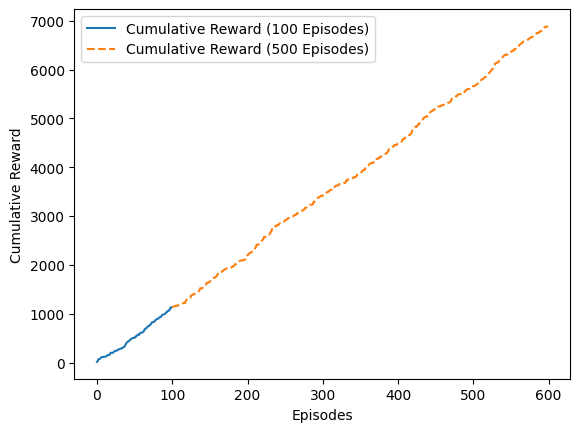

Average Reward (100 Episodes): 11.33
Average Reward (500 Episodes): 11.52


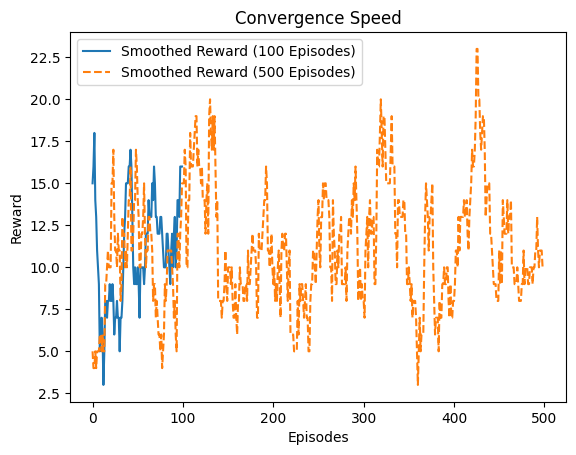

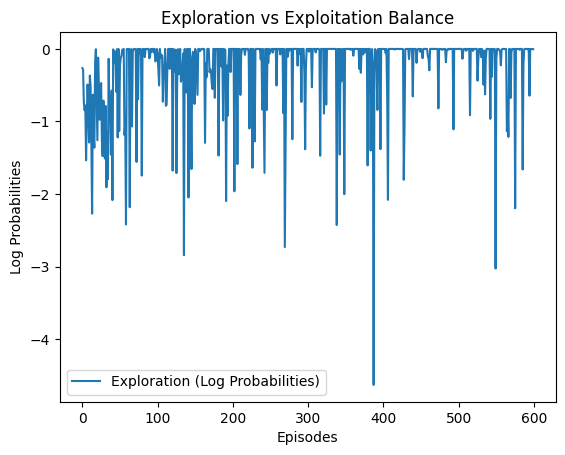

In [10]:
# Training
reward_history_100 = []
reward_history_500 = []
exploration_history_100 = []
exploration_history_500 = []

print("Training for 100 episodes...")
train_ppo_agent(100, 200, exploration_history_100, reward_history_100)

print("Training for 500 episodes...")
train_ppo_agent(500, 200, exploration_history_500, reward_history_500)

# Combine histories for analysis
full_reward_history = reward_history_100 + reward_history_500
full_exploration_history = exploration_history_100 + exploration_history_500

# Plot cumulative reward
plt.plot(np.cumsum(reward_history_100), label="Cumulative Reward (100 Episodes)")
plt.plot(range(len(reward_history_100), len(full_reward_history)), 
         np.cumsum(reward_history_500) + np.cumsum(reward_history_100)[-1], 
         label="Cumulative Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()

# Average Reward
avg_reward_100 = np.mean(reward_history_100)
avg_reward_500 = np.mean(reward_history_500)
print(f"Average Reward (100 Episodes): {avg_reward_100}")
print(f"Average Reward (500 Episodes): {avg_reward_500}")

# Convergence Speed
plt.plot(uniform_filter1d(reward_history_100, size=10), label="Smoothed Reward (100 Episodes)")
plt.plot(uniform_filter1d(reward_history_500, size=10), label="Smoothed Reward (500 Episodes)", linestyle='dashed')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Convergence Speed")
plt.legend()
plt.show()

# Exploration vs Exploitation
plt.plot(range(len(full_exploration_history)), full_exploration_history, label="Exploration (Log Probabilities)")
plt.xlabel("Episodes")
plt.ylabel("Log Probabilities")
plt.title("Exploration vs Exploitation Balance")
plt.legend()
plt.show()



In [11]:
# Evaluation Function
def evaluate_ppo_model(actor, critic, state_representation, episodes=100, max_steps=200):
    total_rewards = []
    total_clicks = 0
    total_add_to_cart = 0
    total_purchases = 0
    total_users = episodes
    total_engagements = 0
    total_revenue = 0

    for episode in range(episodes):
        state = random.choice(state_representation)
        episode_reward = 0

        for _ in range(max_steps):
            # Use Actor model to choose actions (deterministic behavior during evaluation)
            action_probs = actor.predict(np.array([state]), verbose=0)[0]
            action = np.argmax(action_probs)

            # Simulate reward and next state
            reward_type = random.choice(['click', 'add_to_cart', 'purchase', 'no_action'])
            reward = calculate_reward(reward_type)

            # Engagement and revenue metrics
            if reward_type == 'click':
                total_clicks += 1
                total_engagements += 1
            elif reward_type == 'add_to_cart':
                total_add_to_cart += 1
                total_engagements += 1
            elif reward_type == 'purchase':
                total_purchases += 1
                total_engagements += 1
                total_revenue += 15  # Assume $15 revenue per purchase

            episode_reward += reward
            state = random.choice(state_representation)

            # Break if terminal state
            if random.choice([True, False]):
                break

        total_rewards.append(episode_reward)

    # Calculate metrics
    cumulative_reward = sum(total_rewards)
    avg_reward = cumulative_reward / episodes
    ctr = total_clicks / total_users
    engagement_rate = total_engagements / total_users
    rpu = total_revenue / total_users

    metrics = {
        "Cumulative Reward": cumulative_reward,
        "Average Reward per Episode": avg_reward,
        "Click-Through Rate (CTR)": ctr,
        "Engagement Rate": engagement_rate,
        "Revenue Per User (RPU)": rpu
    }

    return metrics


In [12]:
# Evaluate the PPO model
print("Evaluating PPO model after 100 episodes...")
metrics_ppo_100 = evaluate_ppo_model(actor, critic, state_representation, episodes=100)
for metric, value in metrics_ppo_100.items():
    print(f"{metric}: {value:.2f}")

print("\nEvaluating PPO model after 500 episodes...")
metrics_ppo_500 = evaluate_ppo_model(actor, critic, state_representation, episodes=500)
for metric, value in metrics_ppo_500.items():
    print(f"{metric}: {value:.2f}")


Evaluating PPO model after 100 episodes...
Cumulative Reward: 1146.00
Average Reward per Episode: 11.46
Click-Through Rate (CTR): 0.52
Engagement Rate: 1.52
Revenue Per User (RPU): 8.85

Evaluating PPO model after 500 episodes...
Cumulative Reward: 4935.00
Average Reward per Episode: 9.87
Click-Through Rate (CTR): 0.49
Engagement Rate: 1.43
Revenue Per User (RPU): 6.96
